In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Author:** [Rajesh Kumar](https://www.linkedin.com/in/rajesh-kumar-564b8a188/)<br>
**Date created:** 2023/05/10<br>
**Last modified:** 2025/02/16<br>
**Description:** Implement a Transformer block as a Keras layer and use it for text classification

# Setup

In [2]:
import keras
from keras import ops, layers

# from keras import ops
# from keras import layer

# Implement a Transformer block as a layer

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Implement embedding layer
Two embedding layers, one for tokens, one for token index (positions).

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Download and prepare dataset

In [5]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
25000 Training sequences
25000 Validation sequences


# Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Train and Evaluate

In [7]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7169 - loss: 0.5128 - val_accuracy: 0.8618 - val_loss: 0.3113
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9316 - loss: 0.1845 - val_accuracy: 0.8752 - val_loss: 0.3132
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9626 - loss: 0.1110 - val_accuracy: 0.8630 - val_loss: 0.3924
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9794 - loss: 0.0655 - val_accuracy: 0.8503 - val_loss: 0.4791
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9847 - loss: 0.0483 - val_accuracy: 0.8432 - val_loss: 0.6671
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9916 - loss: 0.0280 - val_accuracy: 0.8431 - val_loss: 0.6682
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.8369 - val_loss: 0.7206
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9946 - loss: 0.0170 - val_accuracy: 

In [8]:
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8190 - loss: 2.0673
Validation Loss: 2.0733
Validation Accuracy: 0.8184


In [9]:
y_pred = model.predict(x_val)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [10]:
# from sklearn.metrics import classification_report, confusion_matrix

# # Flatten y_pred_classes and y_val to ensure both are 1D arrays
# y_val_flat = y_val.flatten()
# y_pred_classes_flat = y_pred_classes.flatten()

# print(classification_report(y_val_flat, y_pred_classes_flat))
# print(confusion_matrix(y_val_flat, y_pred_classes_flat))


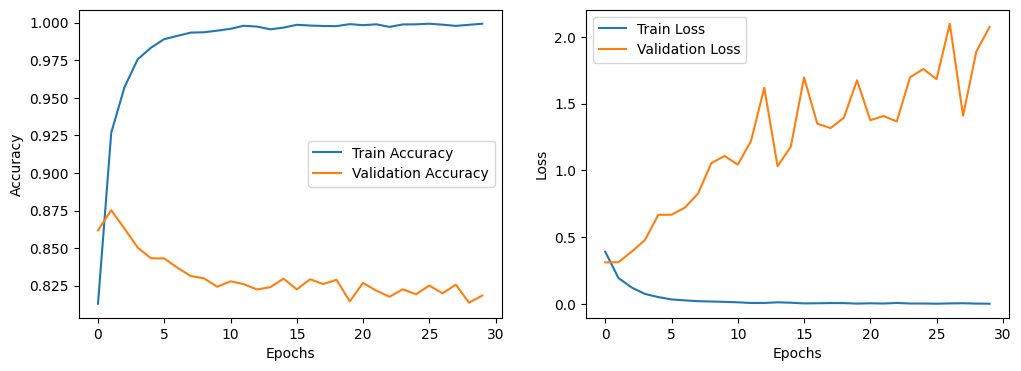

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
